<font color='blue'> **PstFrom** </font>  MF6

In [1]:
import os ; import shutil ; import numpy as np ; import pandas as pd ; import matplotlib.pyplot as plt ; import pyemu ; import flopy 
from pathlib import Path; import sys; import flopy     ; plt.rcParams['font.size'] = 14
model_ws  = os.path.join('model_files_lowres')                              ; sim_ws   = Path("./01_setup_pestpp")  ; sim_ws.mkdir(exist_ok=True) 
shutil.copytree(model_ws,sim_ws,dirs_exist_ok=True) ;sim=flopy.mf6.MFSimulation.load(sim_ws=sim_ws,verbosity_level=0) ;gwf=sim.get_model("freyberg6")
#id_arr  =np.loadtxt(os.path.join(model_ws,"freyberg6.dis_idomain_layer3.txt"))
#top_arr =np.loadtxt(os.path.join(model_ws,"freyberg6.dis_top.txt")) ;top_arr[id_arr==0]=np.nan ;fig=plt.figure(figsize=(3,3)) ;im=plt.imshow(top_arr)
import warnings
warnings.filterwarnings("ignore")

In [2]:
%%capture
sr  = pyemu.helpers.SpatialReference (delr=gwf.dis.delr.array, delc=gwf.dis.delc.array)  ; sr
template_ws = os.path.join(sim_ws,"template")                   ; start_datetime="1-1-2008"     
pf = pyemu.utils.PstFrom  (original_d=sim_ws, new_d=template_ws, 
                           remove_existing=True, longnames=True, spatial_reference=sr, zero_based=False, start_datetime = start_datetime)  

<font color='blue'> **OBS** </font>|<font color='red'> **PAR** </font> 

In [3]:
%%capture
df1 = pd.read_csv(os.path.join (sim_ws,"heads.csv"),index_col=0)             ; df1.to_csv (sim_ws/ "01_heads.csv")
df2 = pd.read_csv(os.path.join (sim_ws, "sfr.csv"), index_col=0)             ; df2.to_csv (sim_ws/ "02_sfr.csv"  ) 
hds_df = pf.add_observations   ("heads.csv",  insfile="heads.csv.ins",  index_cols="time",  use_cols=list(df1.columns.values),  prefix="hds")
sfr_df = pf.add_observations   ("sfr.csv"  , insfile="sfr.csv.ins"   ,  index_cols="time",  use_cols=list(df2.columns.values)) 

vv = pyemu.geostats.ExpVario(contribution=1.0,a=1000)       ; grid_gs = pyemu.geostats.GeoStruct(variograms=vv, transform='log')
temporal_gs = pyemu.geostats.GeoStruct(variograms=pyemu.geostats.ExpVario(contribution=1.0,a=60))    ; ib = gwf.dis.idomain[0].array
pf.add_parameters(filenames="freyberg6.npf_k_layer1.txt"   , par_type="grid"     ,par_name_base="hk_layer_1" ,pargp="hk_layer_1",  
                  zone_array=ib , upper_bound=10.          , lower_bound=0.1     , ult_ubound=100 , ult_lbound=0.01   )
par1 = pd.read_csv(os.path.join(sim_ws, 'freyberg6.npf_k_layer1.txt'))           ; par1.to_csv (sim_ws/ "03_par1.csv"  )

In [4]:
pst = pf.build_pst()  # pst.parameter_data; # pst.observation_data

noptmax:0, npar_adj:706, nnz_obs:725


<font color='blue'> **PEST** </font> 

In [5]:
OBS = pst.observation_data ; PAR = pst.parameter_data ; OBS.to_csv (sim_ws/"04_OBS(1-2).csv");PAR.to_csv (sim_ws/"05_PAR(3).csv") 

In [6]:
pf.mod_sys_cmds.append("mf6")    ; pst = pf.build_pst()   # forward_run.py

noptmax:0, npar_adj:706, nnz_obs:725
2025-06-11 09:44:18.876882 forward_run line:pyemu.os_utils.run(r'mf6')



<font color='red'> **PAR_V2** </font> 

In [7]:
%%capture
pf.add_parameters(filenames="freyberg6.npf_k_layer3.txt"   , par_type="grid"     ,par_name_base="hk_layer_3" ,pargp="hk_layer_3",  
                  zone_array=ib , upper_bound=10.          , lower_bound=0.1     , ult_ubound=100 , ult_lbound=0.01   , geostruct=grid_gs )

In [8]:
pst = pf.build_pst()

noptmax:0, npar_adj:1412, nnz_obs:725
2025-06-11 09:44:19.085940 WARNING: sys_cmd 'pyemu.os_utils.run(r'mf6')
' already in sys cmds, skipping...


In [9]:
PAR_V2 = pst.parameter_data ; PAR_V2.to_csv (sim_ws/"06_PAR(3_V2).csv") 

<font color='red'> **parameter covariance matrix** </font> | <font color='purple'>  ... and prior parameter ensemble </font> 

In [10]:
cov = pf.build_prior()  ; x = cov.x.copy()  ; x[x==0.0] = np.NaN

2025-06-11 09:44:19.130252 starting: building prior covariance matrix
2025-06-11 09:44:19.352262 saving prior covariance matrix to file 01_setup_pestpp\template\01_setup_pestpp.prior.cov
2025-06-11 09:44:20.533286 finished: building prior covariance matrix took: 0:00:01.403034


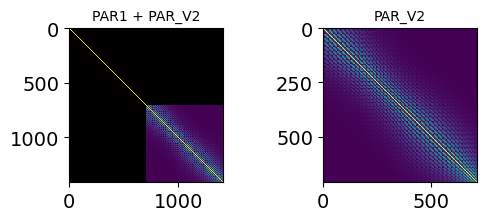

In [11]:
fig = plt.figure(figsize=(6, 2))                             
ax1 = fig.add_subplot(121, aspect="equal") ; im = plt.imshow(x, interpolation='none')             ; plt.gca().set_facecolor('k')
ax2 = fig.add_subplot(122, aspect="equal") ; im = plt.imshow(x[700:,700:], interpolation='none')  ; plt.gca().set_facecolor('k') 
ax1.set_title("PAR1 + PAR_V2", fontsize=10) ; ax2.set_title("PAR_V2", fontsize=10) ; plt.show()

**first block of HK "uncorrelated (diagonal only)** ________ **second block of HK spatially correlated !**

<font color='red'> **as PAR_V3a!** </font> | <font color='blue'> **Well uncertainty** </font>  ...  a constant multiplier parameter for each stress period <font color='blue'> **same pargp** </font> .. dts ..

In [12]:
%%capture
wel_files = [f for f in os.listdir(sim_ws) if "wel_stress_period" in f and f.endswith(".txt")] 
np.savetxt(sim_ws/"07a_wells.csv",wel_files,fmt ="%s",delimiter=",")
w1 = pd.read_csv(os.path.join(sim_ws,wel_files[0]),header=None)                    ; w2 = pd.DataFrame(w1[0]) ; w2.to_csv (sim_ws/ "07b_W01.csv") 

dts = pd.to_datetime(pf.start_datetime) + pd.to_timedelta(np.cumsum(sim.tdis.perioddata.array["perlen"]),unit='d')
for wel_file in wel_files: 
    kper = int(wel_file.split('.')[1].split('_')[-1]) - 1  
    pf.add_parameters(filenames=wel_file, par_type="constant",par_name_base="wel_cn",pargp="wel_cn", upper_bound = 1.5, 
                      lower_bound=0.5,datetime=dts[kper],geostruct=temporal_gs)

In [13]:
pst = pf.build_pst()   ; PAR_V3 = pst.parameter_data     ; PAR_V3.to_csv (sim_ws/"08_PAR(3_V3a).csv") 

noptmax:0, npar_adj:1437, nnz_obs:725
2025-06-11 09:44:21.527650 WARNING: sys_cmd 'pyemu.os_utils.run(r'mf6')
' already in sys cmds, skipping...


In [14]:
cov=pf.build_prior(fmt="none") ; x = cov.x.copy() ;  x[x==0] = np.NaN ; print(x.shape) # pip install objsize ;import objsize ;objsize.get_deep_size(cov)

2025-06-11 09:44:21.570009 starting: building prior covariance matrix
2025-06-11 09:44:21.804021 finished: building prior covariance matrix took: 0:00:00.234012
(1437, 1437)


<font color='red'> **as PAR_V3b!** </font> | <font color='blue'> **Well uncertainty** </font>  ...  a set of multipliers, one for each pumping well

In [15]:
%%capture
pf.add_parameters(filenames=wel_files, par_type="grid",par_name_base="wel_gr",pargp="wel_gr", upper_bound = 1.5, lower_bound=0.5,geostruct=grid_gs )
pst = pf.build_pst() ; PAR_V3 = pst.parameter_data     ; PAR_V3.to_csv (sim_ws/"08_PAR(3_V3b).csv") 

In [16]:
cov = pf.build_prior(fmt="none") ; x = cov.x.copy() ; x[x==0] = np.NaN

2025-06-11 09:44:22.114525 starting: building prior covariance matrix
2025-06-11 09:44:22.356578 finished: building prior covariance matrix took: 0:00:00.242053


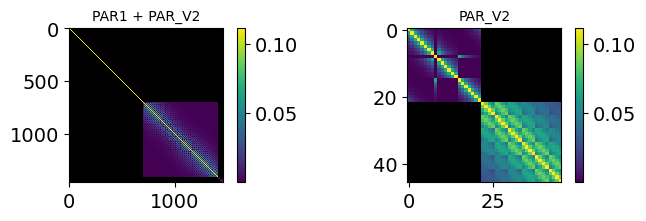

In [17]:
fig = plt.figure(figsize=(8, 2))                             
ax1 = fig.add_subplot(121, aspect="equal") ; im = plt.imshow(x, interpolation='none') ; plt.gca().set_facecolor('k') ; plt.colorbar(im)
ax2 = fig.add_subplot(122, aspect="equal") ; ax2.imshow(x[1415:,1415:], interpolation='none') ; ax2.set_facecolor('k') ; plt.colorbar(im, ax = ax2) 
ax1.set_title("PAR1 + PAR_V2", fontsize=10) ; ax2.set_title("PAR_V2", fontsize=10) ; plt.show()

<font color='red'> **Prior parameter ensemble** </font> 

In [18]:
%%capture
pe = pf.draw(num_reals=100,use_specsim=True)
pe.to_csv(os.path.join(template_ws,"prior.csv"))  ; pe.to_csv (sim_ws/"09_Priors.csv")  # ; display(pe.loc[:,pst.adj_par_names[:5]])

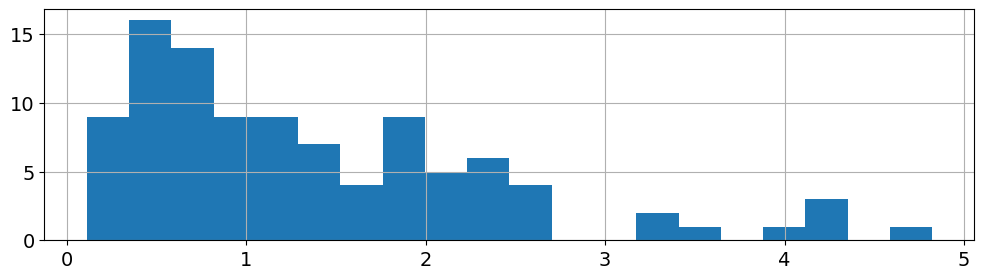

In [19]:
fig, ax = plt.subplots(1,1, figsize=(12,3))  ; h = pe.loc[:,pst.adj_par_names[0]]._df.hist(bins=20)

## **Extra**

<font color='blue'> **OBS - Adding forecasts as "observations" in the control file** </font> 

In [20]:
%%capture
sim = flopy.mf6.MFSimulation.load(sim_ws=sim_ws)   ; m = sim.get_model("freyberg6") ; redis_fac = m.dis.nrow.data / 40  # rediscretization factor
template_ws = os.path.join(sim_ws,"template2")
pf = pyemu.utils.PstFrom(original_d=sim_ws, new_d=template_ws,remove_existing=True,longnames=True, 
                         spatial_reference=m.modelgrid, zero_based=False, start_datetime=start_datetime)    # sys.path.insert(0,".")  

In [21]:
%%capture
pf.add_py_function("helpers.py", "replace_time_with_datetime(csv_file)", is_pre_cmd=None)

In [22]:
%%capture
import helpers
out_file,df = helpers.replace_time_with_datetime(os.path.join(template_ws, "sfr.csv"))
out_file = os.path.split(out_file)[-1] ; pf.post_py_cmds.append("replace_time_with_datetime('sfr.csv')")  
pf.add_observations(out_file, insfile=out_file+".ins", index_cols="datetime", use_cols=list(df.columns.values),prefix="sfr", ofile_sep=",")
pst = pf.build_pst()   ; OBSextra1 = pst.observation_data                                            ; OBSextra1.to_csv (sim_ws/"10a_.csv") 

In [23]:
%%capture
out_file,df = helpers.replace_time_with_datetime(os.path.join(template_ws, "heads.csv"))
out_file = os.path.split(out_file)[-1] ; pf.post_py_cmds.append("replace_time_with_datetime('heads.csv')")
pf.add_observations(out_file, insfile=out_file+".ins", index_cols="datetime", use_cols=list(df.columns.values),prefix="hds", ofile_sep=",")
pst = pf.build_pst()   ; OBSextra2 = pst.observation_data                                            ; OBSextra2.to_csv  (sim_ws/"10b.csv") 

<font color='red'> **PAR - Extra/ others Parameters** </font> ... RCH, ...

In [24]:
%%capture
grid_v     = pyemu.geostats.ExpVario(contribution=1.0,a=500)   ; grid_gs     = pyemu.geostats.GeoStruct(variograms=grid_v)
pp_v       = pyemu.geostats.ExpVario(contribution=1.0, a=2000) ; pp_gs       = pyemu.geostats.GeoStruct(variograms=pp_v)
rch_v      = pyemu.geostats.ExpVario(contribution=1.0, a=1000) ; rch_gs      = pyemu.geostats.GeoStruct(variograms=rch_v)
temporal_v = pyemu.geostats.ExpVario(contribution=1.0,a=60)    ; temporal_gs = pyemu.geostats.GeoStruct(variograms=temporal_v)
pf.extra_py_imports.append('flopy') ; ib = m.dis.idomain[0].array
tags = {"npf_k_":[0.1,10.],"npf_k33_":[.1,10],"sto_ss":[.1,10],"sto_sy":[.9,1.1],"rch_recharge":[.5,1.5]}
dts  = pd.to_datetime("1-1-2018") + pd.to_timedelta(np.cumsum(sim.tdis.perioddata.array["perlen"]),unit="d")
for tag,bnd in tags.items():
    lb,ub = bnd[0],bnd[1]
    arr_files = [f for f in os.listdir(template_ws) if tag in f and f.endswith(".txt")]
    if len(arr_files) == 0:
        print("warning: no array files found for ",tag)
        continue
    
    for arr_file in arr_files:
        arr = np.loadtxt(os.path.join(template_ws,arr_file)).reshape(ib.shape) ; np.savetxt(os.path.join(template_ws,arr_file),arr,fmt="%15.6E")
    
    if "rch" in tag:
        pf.add_parameters(filenames=arr_files, par_type="grid", par_name_base="rch_gr",pargp="rch_gr", 
                          zone_array=ib, upper_bound=ub, lower_bound=lb,geostruct=rch_gs)
        for arr_file in arr_files:
            kper = int(arr_file.split('.')[1].split('_')[-1]) - 1
            pf.add_parameters(filenames=arr_file,par_type="constant",par_name_base=arr_file.split('.')[1]+"_cn",
                              pargp="rch_const",zone_array=ib,upper_bound=ub,lower_bound=lb,geostruct=temporal_gs,datetime=dts[kper])
    else:
        for arr_file in arr_files:
            pf.add_parameters(filenames=arr_file,par_type="grid",par_name_base=arr_file.split('.')[1]+"_gr",
                              pargp=arr_file.split('.')[1]+"_gr",zone_array=ib,upper_bound=ub,lower_bound=lb,geostruct=grid_gs)
            pf.add_parameters(filenames=arr_file, par_type="pilotpoints",par_name_base=arr_file.split('.')[1]+"_pp",
                              pargp=arr_file.split('.')[1]+"_pp",zone_array=ib,upper_bound=ub,lower_bound=lb,pp_space=int(5 * redis_fac),geostruct=pp_gs)
list_files = [f for f in os.listdir(sim_ws) if 
			  "freyberg6.wel_stress_period_data_" 
              in f and f.endswith(".txt")]
for list_file in list_files:
    kper = int(list_file.split(".")[1].split('_')[-1]) - 1
    pf.add_parameters(filenames=list_file,par_type="constant",par_name_base="twel_mlt_{0}".format(kper),pargp="twel_mlt".format(kper),
                      index_cols=[0,1,2],use_cols=[3],upper_bound=1.5,lower_bound=0.5, datetime=dts[kper], geostruct=temporal_gs)
    pf.add_parameters(filenames=list_file, par_type="grid", par_name_base="wel_grid_{0}".format(kper),
                      pargp="wel_{0}".format(kper), index_cols=[0, 1, 2], use_cols=[3],upper_bound=1.5, lower_bound=0.5)

pf.add_parameters(filenames="freyberg6.sfr_packagedata.txt", par_name_base="sfr_rhk",pargp="sfr_rhk", index_cols=[0,1,2,3], 
                  use_cols=[9], upper_bound=10.,lower_bound=0.1,par_type="grid")

In [25]:
pst = pf.build_pst()   ; PAR_V4extra = pst.parameter_data     ; PAR_V4extra.to_csv (sim_ws/"11_PAR_V4extra.csv") 

noptmax:0, npar_adj:9766, nnz_obs:725


## **Final bits** .. to write .. quiçá run (-1) .. **then ..**

In [30]:
%%capture
pf.mod_sys_cmds.append("mf6")  ; pst = pf.build_pst('freyberg6.pst',version=2)
pe = pf.draw(300, use_specsim=True) ; pe.to_binary(os.path.join(template_ws, "prior.jcb"))
pst.control_data.noptmax = 0  ; pst.write(os.path.join(pf.new_d, "freyberg.pst"))

pyemu.os_utils.run("{0} freyberg.pst".format(os.path.join("pestpp-ies")), cwd=pf.new_d)  ; res_file = os.path.join(pf.new_d, "freyberg.base.rei")
assert os.path.exists(res_file), res_file
pst.set_res(res_file) ; print(pst.phi) ; pst.control_data.noptmax = -1 ; pst.pestpp_options["ies_par_en"] = "prior.jcb"
pst.write(os.path.join(pf.new_d, "freyberg6.pst"),version=2)   # doesnt work after (..) %%capture